In [2]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [3]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [4]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [5]:
df = pd.read_csv(INPUT_FILE)

In [6]:
sl = df.loc[df.country_name=='Malawi']

In [7]:
sl.shape

(12191, 40)

In [8]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [9]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [10]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


0

In [11]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

In [12]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [13]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [14]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [16]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[500,1000, 1500]} #small data set
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [500, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
print('model fit for inner CV for Malawi')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Malawi
Shape of input params=  (7314, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best grid score on inner CV 0.825540060159
Accuracy for inner nested_cv model : 0.8302
AUC Score (test) for inner_nested cv_model: 0.841888
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=123, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [18]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 123
Accuracy for outer nested_cv model on training data: 0.8664
AUC Score (Train) for outer nested_cv model: 0.913702
AUC Score (Test) for outer nested_cv model: 0.845086
AUC Score (Holdout) for outer nested_cv model: 0.848526
Accuracy for outer nested_cv model on holdout data: 0.8323


In [17]:
metrics.log_loss(y_train.values, dtrain_predprob)

0.32513582188634027

# Fairly stable across test and holdout

In [18]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [19]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.84842257  0.85167389  0.83556521  0.85542496  0.84272755]
Accuracy full-data : 0.8313
AUC Score full-data: 0.846344


(array([ 0.,  0.,  0., ...,  0.,  0.,  1.]), array([[ 0.79695225,  0.20304777],
        [ 0.80321991,  0.1967801 ],
        [ 0.79325503,  0.20674498],
        ..., 
        [ 0.86276162,  0.13723835],
        [ 0.86110294,  0.13889709],
        [ 0.06421155,  0.93578845]], dtype=float32))

In [20]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [21]:
name = sl.country_name.unique()[0]
save_model(model_outer, name)

saved as Malawi_pickle.sav


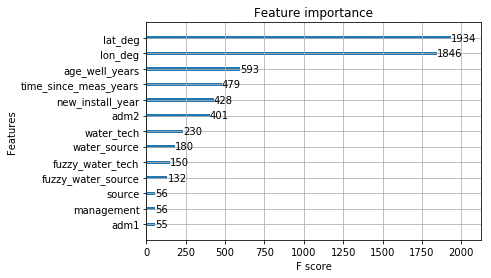

In [22]:
xgb.plot_importance(model_outer)

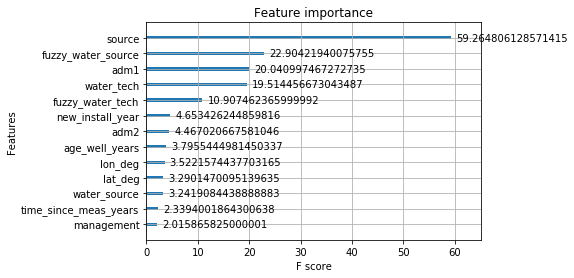

In [23]:
xgb.plot_importance(model_outer, importance_type='gain')

In [24]:
model_outer.feature_importances_

array([ 0.02752294,  0.0351682 ,  0.00856269,  0.00856269,  0.00840979,
        0.06131499,  0.        ,  0.29571864,  0.28226301,  0.06544343,
        0.09067278,  0.07324159,  0.02018349,  0.02293578], dtype=float32)

In [25]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

In [26]:
# from eli5.sklearn import PermutationImportance
# perm = PermutationImportance(model_outer).fit(X_test, y_test)
# eli5.show_weights(perm)

In [27]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

In [28]:
imp

array([-0.0021241 , -0.0250997 , -0.00154071, -0.0138011 , -0.00203118,
       -0.00812968,  0.        , -0.03699273, -0.03864425, -0.01263879,
       -0.01343579, -0.00594563, -0.02432907, -0.0215905 ])

In [29]:
X_test.columns

Index(['water_source', 'water_tech', 'management', 'source', 'adm1', 'adm2',
       'pay', 'lat_deg', 'lon_deg', 'new_install_year', 'age_well_years',
       'time_since_meas_years', 'fuzzy_water_source', 'fuzzy_water_tech'],
      dtype='object')

In [31]:
def plot_perm_importance(perm_importance, X_test):
    #takes a permutatino importance and the input data from it and plots
    df = pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0)
    df.rename(columns={0:'Feature Importance'},inplace=True)
    df.sort_values(by='Feature Importance').plot(kind='barh',
                    title='Feature Importance', legend=None)


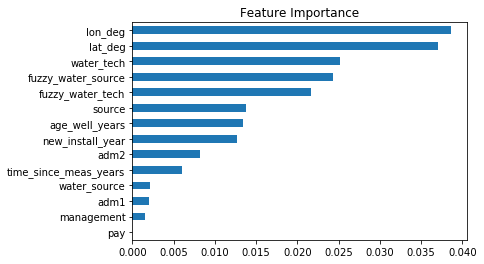

In [32]:
plot_perm_importance(imp, X_test)

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

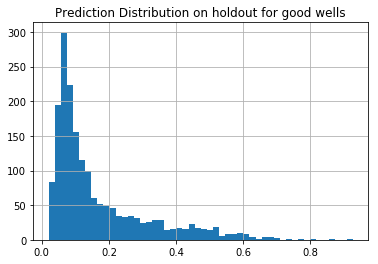

In [34]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


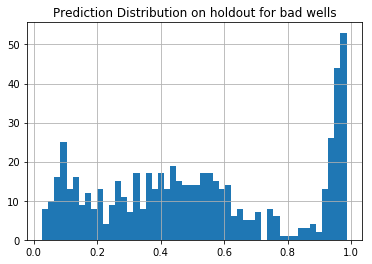

In [35]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 0.61674091,  1.23348183,  1.91874951,  1.16495506,  1.16495506,
         1.02790152,  0.61674091,  1.16495506,  0.54821415,  0.54821415,
         1.43906213,  0.61674091,  1.23348183,  1.09642829,  1.23348183,
         1.37053537,  1.02790152,  1.71316921,  1.3020086 ,  1.09642829,
         1.09642829,  1.3020086 ,  1.78169598,  1.02790152,  1.09642829,
         0.68526768,  0.41116061,  0.41116061,  0.47968738,  0.34263384,
         0.54821415,  0.13705354,  0.06852677,  0.2055803 ,  0.27410707,
         0.27410707,  0.41116061,  1.02790152,  2.74107073,  5.27656116]),
 array([ 0.02672639,  0.05068836,  0.07465033,  0.09861229,  0.12257426,
         0.14653623,  0.17049819,  0.19446016,  0.21842213,  0.24238409,
         0.26634606,  0.29030803,  0.31426999,  0.33823196,  0.36219393,
         0.38615589,  0.41011786,  0.43407983,  0.45804179,  0.48200376,
         0.50596572,  0.52992769,  0.55388966,  0.57785162,  0.60181359,
         0.62577556,  0.64973752,  0.67369949,  0

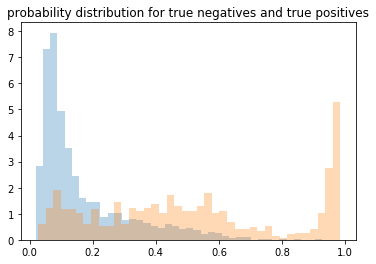

In [36]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### Some separation, will need to adjust the threshold

In [37]:
def evaluate_prediction_thresholds(y_true, y_pred_probs, recall_val):
    import numpy as np
    d = dict()
    for i in np.linspace(0,0.5, num=20):
        best = 0
        test = np.where(y_pred_probs > i, 1,0)
        recall = metrics.recall_score(y_true, test)
        precision = metrics.precision_score(y_true, test)
        f_score = metrics.f1_score(y_true, test, average='binary')
        d[i]=recall, precision, f_score

    frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
    frame.columns=(['recall','precision', 'f1_score'])
    frame = frame[frame.recall>recall_val]
    return frame

In [38]:
evaluate_prediction_thresholds(y_test, dtest_predprob, .7)

,recall,precision,f1_score
0.000000,1.000000,0.249795,0.399737
0.026316,0.998358,0.250929,0.401055
0.052632,0.985222,0.275609,0.430725
0.078947,0.958949,0.335632,0.497233
0.105263,0.911330,0.391121,0.547337
0.131579,0.865353,0.430908,0.575328
0.157895,0.829228,0.462031,0.593420
0.184211,0.798030,0.492901,0.609404
0.210526,0.761905,0.514412,0.614163
0.236842,0.717570,0.532278,0.611189


In [39]:
evaluate_prediction_thresholds(y_holdout, dholdout_predprob, 0.7)

,recall,precision,f1_score
0.000000,1.000000,0.249692,0.399606
0.026316,1.000000,0.251549,0.401980
0.052632,0.985222,0.273100,0.427655
0.078947,0.952381,0.323661,0.483132
0.105263,0.898194,0.374914,0.529014
0.131579,0.873563,0.417255,0.564756
0.157895,0.844007,0.452465,0.589112
0.184211,0.821018,0.477555,0.603865
0.210526,0.794745,0.502075,0.615385
0.236842,0.779967,0.528953,0.630392


## Modeling Decision: Threshold of 0.237 gives a recall > 0.81 and a precision > 0.51 on both test and holdout. Will use as threshold. Not great but want to have at least a 50% chance of investigating a real bad well (prioritization) and balanced with catching as many as possible (recall).

### Create predictions for the out years based on data

In [19]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
15016,17,23,4,10,9,44,0,-14.0322,34.1128,59,280.6,6.6,10,1


In [20]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4

In [21]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today['age_well_years'][:1])
print(X_1year['age_well_years'][:1])
print(X_3year['age_well_years'][:1])
print(X_5year['age_well_years'][:1])

       age_well_years  time_since_meas_years
15016           274.0                    6.6
15016    280.6
Name: age_well_years, dtype: float64
15016    281.6
Name: age_well_years, dtype: float64
15016    283.6
Name: age_well_years, dtype: float64
15016    285.6
Name: age_well_years, dtype: float64


# Get Predictions for Today, 1, 3 and 5 years out

In [22]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [23]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [45]:
#old way before adjusting time since meas
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,12191.000000,12191.000000,12191.000000,12191.000000,12191.000000
mean,0.249692,0.145517,0.161431,0.154376,0.157001
std,0.432853,0.352636,0.367943,0.361324,0.363817
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
#with corrected time since measurement
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,12191.000000,12191.000000,12191.000000,12191.000000,12191.000000
mean,0.249692,0.145517,0.148142,0.157657,0.165532
std,0.432853,0.352636,0.355255,0.364434,0.371675
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of 0.237 for our prediction threshold

# Also coerce well status to be "broken" if it was ever "broken" in the past 

In [25]:
threshold = 0.237
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [27]:
mal = df.loc[df.country_name=='Malawi']

In [48]:
coerced = append_outyear_predictions(mal, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [49]:
#before correction
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,12191.000000,12191.000000,12191.000000,12191.000000,12191.000000
mean,0.249692,0.413420,0.456730,0.471331,0.482323
std,0.432853,0.492467,0.498145,0.499198,0.499708
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
#After correction
coerced2 = append_outyear_predictions(mal, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,12191.000000,12191.000000,12191.000000,12191.000000,12191.000000
mean,0.249692,0.413420,0.419408,0.428185,0.434993
std,0.432853,0.492467,0.493482,0.494836,0.495776
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
#check to see if it worked
sl[(sl.status_binary==1)&(sl.status_binary<sl.today_preds)].shape

(0, 23)

In [51]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==1][(sl.today_preds<sl.one_year_preds)].shape

(122, 23)

In [52]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
print(sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].shape)
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].tail(10)

(149, 23)


,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech,status_binary,today_preds,today_predprob,one_year_preds,one_year_predprob,three_year_preds,three_year_predprob,five_year_preds,five_year_predprob
289272,__MISSING__,AfriDev Handpump,__MISSING__,Water For People,Chikhwawa,Chapananga,__MISSING__,-15.8012,34.3067,1989-01-01 00:00:00,27.3,1.9,__MISSING__ Unknown,Afridev,0.0,0.0,0.456991,1.0,0.525691,0.0,0.494249,0.0,0.449183
289334,__MISSING__,AfriDev Handpump,__MISSING__,Water For People,Chikhwawa,Chapananga,__MISSING__,-15.7998,34.3019,1989-01-01 00:00:00,27.3,1.9,__MISSING__ Unknown,Afridev,0.0,0.0,0.443612,1.0,0.512198,0.0,0.480745,0.0,0.435849
326804,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.0326,35.1751,__MISSING__,274.0,1.4,Hand Pump,Afridev,0.0,0.0,0.427756,1.0,0.540324,0.0,0.467236,0.0,0.470447
326805,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.0334,35.1762,2004-01-01 00:00:00,12.8,1.4,Hand Pump,Afridev,0.0,0.0,0.360407,1.0,0.508383,0.0,0.452120,0.0,0.458613
326822,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.1249,35.2238,__MISSING__,274.0,1.2,Hand Pump,Afridev,0.0,0.0,0.101294,1.0,0.501847,0.0,0.390911,0.0,0.442695
327030,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.0309,35.0681,__MISSING__,274.0,1.2,Hand Pump,Afridev,0.0,0.0,0.148182,1.0,0.573057,0.0,0.446763,1.0,0.507534
327031,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.0309,35.0681,2003-01-01 00:00:00,13.9,1.2,Hand Pump,Afridev,0.0,0.0,0.181366,1.0,0.540576,0.0,0.426601,1.0,0.500541
327035,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.1256,35.2265,__MISSING__,274.0,1.2,Hand Pump,Afridev,0.0,0.0,0.101294,1.0,0.501847,0.0,0.390911,0.0,0.442695
327037,Hand Pumps,Afridev,__MISSING__,Madzi Alipo,__MISSING__,__MISSING__,__MISSING__,-17.1250,35.2279,__MISSING__,274.0,1.2,Hand Pump,Afridev,0.0,0.0,0.101294,1.0,0.501847,0.0,0.390911,0.0,0.442695
332703,__MISSING__,handpump,__MISSING__,Mzuzu University,__MISSING__,__MISSING__,__MISSING__,34.2520,-13.0917,__MISSING__,274.0,0.7,__MISSING__ Unknown,Hand Pump,0.0,0.0,0.450164,1.0,0.537171,1.0,0.557827,1.0,0.527231


In [128]:
sl[sl.status_binary==0][(sl.today_preds<sl.three_year_preds)].tail(10)

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech,status_binary,today_preds,today_predprob,one_year_preds,one_year_predprob,three_year_preds,three_year_predprob,five_year_preds,five_year_predprob
128560,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kandahar,Panjwayi,__MISSING__,31.5365,65.3928,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.144617,1,0.356342,1,0.302319,1,0.115313
128564,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kandahar,Panjwayi,__MISSING__,31.6595,65.3792,2002-01-01 00:00:00,2.8,13.4,__MISSING__ Unknown,Tube Well,0.0,0,0.189792,0,0.162619,1,0.308130,1,0.118879
128568,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kandahar,Panjwayi,__MISSING__,31.4812,65.5336,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.149667,1,0.365624,1,0.310874,1,0.119483
128569,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kandahar,Panjwayi,__MISSING__,31.6680,65.3917,2002-01-01 00:00:00,4.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.115190,1,0.267429,1,0.242118,1,0.104465
128595,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8211,69.6494,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.166580,1,0.259808,1,0.417279,1,0.251417
128602,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8419,69.6478,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.145809,1,0.252279,1,0.379141,1,0.222646
128603,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7843,69.6596,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.105824,0,0.172069,1,0.297753,1,0.165877
128618,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.8180,69.6524,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.164370,1,0.256742,1,0.413392,1,0.248417
128628,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7995,69.6539,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.120395,0,0.193785,1,0.329027,1,0.186987
128638,__MISSING__,TUBE WELL,__MISSING__,DACAAR,Kapisa,Tagab,__MISSING__,34.7962,69.6543,2003-01-01 00:00:00,3.1,12.1,__MISSING__ Unknown,Tube Well,0.0,0,0.142511,0,0.225920,1,0.373207,1,0.218301


In [120]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.93      0.87      8399
        1.0       0.75      0.51      0.60      3571

avg / total       0.79      0.80      0.79     11970



In [53]:
#outputting with consistent failed wells coerced over time
coerced.to_csv('Malawi_w_outyear_predictions_coerced.csv')

In [29]:
coerced2.to_csv('Malawi_w_outyear_predictions_coerced_correct_time2.csv')